In [2]:
import os
import glob
import random
import shutil
import tensorflow as tf
from tensorflow.keras import preprocessing
from tensorflow.keras import models, layers
from tqdm import tqdm

In [32]:
# Where the text files are going to live.
dataset_path = "dataset"
dataset_path_all = os.path.join(dataset_path, "all")
dataset_path_train = os.path.join(dataset_path, "train")
dataset_path_valid = os.path.join(dataset_path, "valid")
# Just use 20 files.
file_number = 20


In [34]:

# Just use 20 files.
file_number = 20

# Gather the corpus if it has not been gathered yet.
if not os.path.exists(dataset_path):

    # Create all the folders.
    for path in [dataset_path, dataset_path_all, dataset_path_train, dataset_path_valid]:
        if not os.path.exists(path):
            os.mkdir(path)

    # Clone the repo.
    !git clone https://github.com/vilmibm/lovecraftcorpus
        
    # Find all the files.
    paths_all = glob.glob("lovecraftcorpus/*.txt")
    print(sorted(paths_all))

    # Do not use all.
    paths_all = paths_all[:file_number]

    # Split 80/20.
    split_index = int(len(paths_all) * 0.8)
    paths_train = paths_all[:split_index]
    paths_valid = paths_all[split_index:]

    # Copy files.
    def copy(paths, destination):
        for path in paths:
            shutil.copy2(path, destination)
    copy(paths_all, dataset_path_all)
    copy(paths_train, dataset_path_train)
    copy(paths_valid, dataset_path_valid)

    # Delete repo.
    !del -rf lovecraftcorpus

    # Done.
    print("Corpus downloaded.")

In [35]:
!dir /b dataset
print("")
!dir /b dataset\all
print("")
!dir /b dataset\train
print("")
!dir /b dataset\valid

all
train
valid

alchemist.txt
arthur_jermyn.txt
azathoth.txt
beast.txt
beyond_wall_of_sleep.txt
book.txt
celephais.txt
charles_dexter_ward.txt
clergyman.txt
colour_out_of_space.txt
cool_air.txt
crawling_chaos.txt
cthulhu.txt
dagon.txt
descendent.txt
doorstep.txt
dreams_in_the_witch.txt
dunwich.txt
erich_zann.txt
ex_oblivione.txt

alchemist.txt
arthur_jermyn.txt
azathoth.txt
beast.txt
beyond_wall_of_sleep.txt
book.txt
celephais.txt
charles_dexter_ward.txt
clergyman.txt
colour_out_of_space.txt
cool_air.txt
crawling_chaos.txt
cthulhu.txt
dagon.txt
descendent.txt
doorstep.txt

dreams_in_the_witch.txt
dunwich.txt
erich_zann.txt
ex_oblivione.txt


In [36]:
batch_size = 32
seed = 42

def create_dataset(dataset_path):
    dataset = preprocessing.text_dataset_from_directory(
        dataset_path,
        labels=None,
        batch_size=batch_size,
        seed=seed
    )

    return dataset


dataset_original_all = create_dataset(dataset_path_all)
dataset_original_train = create_dataset(dataset_path_train)
dataset_original_valid = create_dataset(dataset_path_valid)

Found 20 files belonging to 1 classes.
Found 16 files belonging to 1 classes.
Found 4 files belonging to 1 classes.


In [37]:
# for x in dataset_original_all.take(1):
#     print(x)

In [43]:
vocabulary_size = 10_000


encoder = layers.TextVectorization(
    max_tokens=vocabulary_size,
    standardize="lower_and_strip_punctuation",
    split="whitespace",
    output_mode="int"
)

encoder.adapt(dataset_original_all)


vocabulary = encoder.get_vocabulary()

print(vocabulary[:100])

['', '[UNK]', 'the', 'and', 'of', 'to', 'a', 'in', 'was', 'he', 'had', 'that', 'his', 'i', 'it', 'as', 'with', 'at', 'which', 'from', 'for', 'on', 'but', 'not', 'were', 'by', 'him', 'be', 'all', 'an', 'this', 'they', 'there', 'or', 'no', 'my', 'when', 'could', 'one', 'have', 'been', 'would', 'what', 'some', 'so', 'old', 'about', 'me', 'its', 'out', 'more', 'is', 'only', 'seemed', 'their', 'now', 'very', 'before', 'who', 'up', 'did', 'you', 'after', 'then', 'time', 'into', 'them', 'than', 'ward', 'must', 'found', 'any', 'even', 'where', 'man', 'like', 'down', 'if', 'came', 'through', 'strange', 'her', 'great', 'though', 'never', 'upon', 'those', 'saw', 'house', 'night', 'willett', 'heard', 'thing', 'room', 'over', 'other', 'whose', 'she', 'curwen', 'come']


In [39]:
sequence_length = 32

def create_dataset_for_autoregression(dataset):
      x_inputs = []
      y_outputs = []

      padding_token_id = vocabulary.index("") # 0

      for books in dataset:
            books = encoder(books).numpy()

            for book in tqdm(books):
                  # print(books)
                  padding = [padding_token_id]*sequence_length
                  book = padding +list(book)
                  # print(padding)

                  for start_index in range(0, len(book)-sequence_length):
                        x = book[start_index : start_index + sequence_length]
                        y = book[start_index + sequence_length]

                        # print(x)
                        # print(y)
                        # print("")
                        # if start_index == 34:
                        #       assert False
                        if y == padding_token_id:
                              break

                        x_inputs += [x]
                        y_outputs += [y]

      print("Finished")
      print(len(x_inputs), len(y_outputs))
      return tf.data.Dataset.from_tensor_slices((x_inputs, y_outputs))

dataset_train = create_dataset_for_autoregression(dataset_original_train)
dataset_valid = create_dataset_for_autoregression(dataset_original_valid)

100%|██████████| 16/16 [00:00<00:00, 48.72it/s]


Finished
115311 115311


100%|██████████| 4/4 [00:00<00:00, 114.30it/s]


Finished
36011 36011


In [40]:
for x, y in dataset_train.take(34):
    print(x.numpy())
    print(y.numpy())
    print("")

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
2

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2]
92

[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  2 92]
21

[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  2 92 21]
2

[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  2 92 21  2]
5166

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    2
   92   21    2 5166]
13

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    2   92
   21    2 5166   13]
14

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    2   92   21
    2 5166   13   14]
51

[   0    0    0    0    0    0    0    0    0  

In [46]:
embedding_size = 128

model = models.Sequential()
model.add(layers.Embedding(vocabulary_size, embedding_size, input_length=sequence_length))
model.add(layers.LSTM(512))
model.add(layers.Dense(vocabulary_size, activation="softmax"))

model.summary()


model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

history = model.fit(
    dataset_train.cache().shuffle(90_000).batch(512),
    validation_data=dataset_valid.cache().batch(512),
    epochs=10
)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 32, 128)           1280000   
                                                                 
 lstm_3 (LSTM)               (None, 512)               1312768   
                                                                 
 dense_2 (Dense)             (None, 10000)             5130000   
                                                                 
Total params: 7,722,768
Trainable params: 7,722,768
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
226/226 [==============================] - 52s 208ms/step - loss: 6.8430 - accuracy: 0.0692 - val_loss: 6.8546 - val_accuracy: 0.0960
Epoch 2/10
226/226 [==============================] - 48s 212ms/step - loss: 6.3346 - accuracy: 0.1040 - val_loss: 6.6782 - val_accuracy: 0.1176
Epoch 3/10
226/226

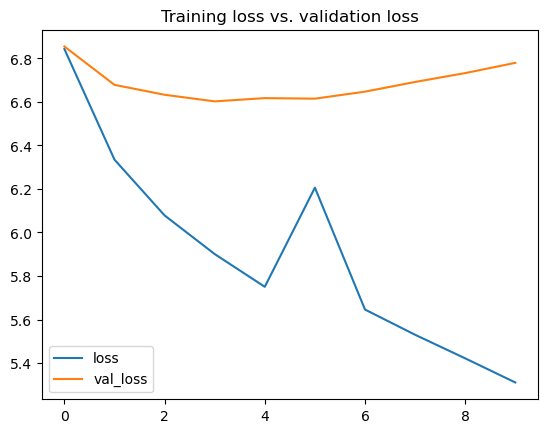

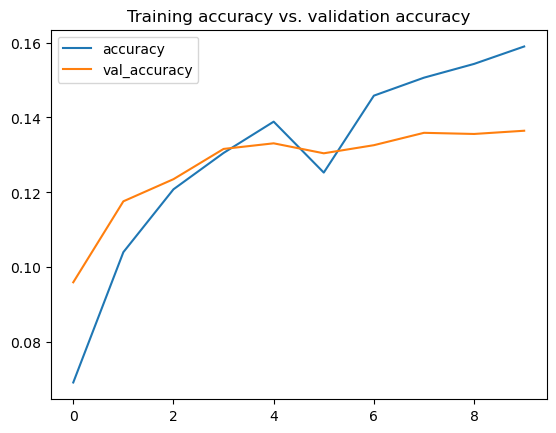

In [47]:
import matplotlib.pyplot as plt

def render_history(history):
    plt.title("Training loss vs. validation loss")
    plt.plot(history.history["loss"], label="loss")
    plt.plot(history.history["val_loss"], label="val_loss")
    plt.legend()
    plt.show()
    plt.close()

    plt.title("Training accuracy vs. validation accuracy")
    plt.plot(history.history["accuracy"], label="accuracy")
    plt.plot(history.history["val_accuracy"], label="val_accuracy")
    plt.legend()
    plt.show()
    plt.close()

render_history(history)

In [50]:
import numpy as np
def decode(indices):
    return " ".join([vocabulary[index] for index in indices if vocabulary[index] != ""])
def generate(model, seed_text, generated_sequence_length, temperature):

    input_sequence = encoder(seed_text).numpy()

    generated_sequence = list(input_sequence[::])

    # Pad.
    padding = [0] * (sequence_length - len(input_sequence))
    input_sequence = padding + list(input_sequence)

    # Generate the sequence by repeatedly predicting.
    while len(generated_sequence) < generated_sequence_length:
        prediction = model.predict(np.expand_dims(input_sequence, axis=0))
        predicted_index = get_index_from_prediction(prediction[0], temperature)
        generated_sequence.append(predicted_index)
        input_sequence = input_sequence[1:]
        input_sequence.append(predicted_index)

    # Convert the generated sequence to a string.
    text = decode(generated_sequence)
    print(text)
    print("")

        
def get_index_from_prediction(prediction, temperature=0.0):
    """ Gets an index from a prediction. """

    # Zero temperature - use the argmax.
    if temperature == 0.0:
        return np.argmax(prediction)

    # Non-zero temperature - do some random magic.
    else:
        prediction = np.asarray(prediction).astype('float64')
        prediction = np.log(prediction) / temperature
        exp_prediction= np.exp(prediction)
        prediction = exp_prediction / np.sum(exp_prediction)
        probabilities = np.random.multinomial(1, prediction, 1)
        return np.argmax(probabilities)
  

generate(model, "we are all doomed", 100, temperature=1.0)

1/1 [==============================] - 0s 28ms/step
we are all doomed he would wonderand stay them back or all like changed the benevolent gulf could not be in this animal startling man was likely to conjunction one from the doom he became viewing the ancient ones was to different because it must be led low find in ye shafts and [UNK] black sabaoth stately and charless elder chamber i professed in design that the house had expected to come to contain she should see water himself presented and he before at a residence came blew it at acid at sight and sterile [UNK] order to think of

